#Importing Functions

In [ ]:
# Tensorflow version 2.4.1

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow
tensorflow.__version__

'2.5.0'

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from scipy import ndimage
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import BatchNormalization,ReLU,GlobalAveragePooling1D,MaxPooling1D,LSTM,TimeDistributed,GlobalAveragePooling2D
#from keras.utils import to_categorical
from keras.models import save_model, load_model
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import  plot_model
from keras.models import Model,save_model,load_model
from keras.layers import Input
from keras.layers.merge import concatenate

from datetime import datetime
from packaging import version

import os
import tempfile
import os
import tensorflow as tf
from tensorflow import expand_dims
from tensorflow import keras
%load_ext tensorboard

In [ ]:
!pip install -U tensorboard_plugin_profile

     |████████████████████████████████| 1.2MB 3.0MB/s 


#Loading Dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
import zipfile
with zipfile.ZipFile('/content/UCI HAR Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('')

--2021-06-09 06:08:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  41.4MB/s    in 1.4s    

2021-06-09 06:09:01 (41.4 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
def load_file(filepath):
  dataframe=read_csv(filepath,header=None,delim_whitespace=True)
  return dataframe.values

In [ ]:
def load_group(filenames,prefix=''):
  loaded=list()
  for name in filenames:
    data=load_file(prefix+name)
    loaded.append(data)
  loaded=dstack(loaded)
  return loaded

In [ ]:
def load_dataset_group(group,prefix=''):
  filepath=prefix+group+'/Inertial Signals/'
  filenames=list()
  filenames+=['total_acc_x_'+group+'.txt','total_acc_y_'+group+'.txt','total_acc_z_'+group+'.txt']
  filenames+=['body_acc_x_'+group+'.txt','body_acc_y_'+group+'.txt','body_acc_z_'+group+'.txt']
  filenames+=['body_gyro_x_'+group+'.txt','body_gyro_y_'+group+'.txt','body_gyro_z_'+group+'.txt']
  X=load_group(filenames,filepath)
  y=load_file(prefix+group+'/y_'+group+'.txt')
  return (X,y)


In [ ]:
def load_dataset(prefix=''):
  trainX,trainy=load_dataset_group('train',prefix+'UCI HAR Dataset/')
  print(trainX.shape,trainy.shape)
  testX,testy=load_dataset_group('test',prefix+'UCI HAR Dataset/')
  print(testX.shape,testy.shape)
  trainy=trainy-1
  testy=testy-1
  trainy=tf.compat.v1.keras.utils.to_categorical(trainy)
  testy=tf.compat.v1.keras.utils.to_categorical(testy)
  print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  return trainX, trainy, testX, testy

In [ ]:
def scale_data(trainX, testX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize

	s = StandardScaler()
		# fit on training data
	s.fit(longX)
		# apply to training and test data
	longX = s.transform(longX)
	flatTrainX = s.transform(flatTrainX)
	flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

##Function for model size

In [ ]:
def get_zipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  zipped_file = file+'.zip'
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

##1. CNN MODEL


In [ ]:
trainX,trainy,testX,testy=load_dataset()
verbose,epochs,batch_size=1,500,32 #Epoch 500
n_timesteps,n_features,n_outputs=trainX.shape[1],trainX.shape[2],trainy.shape[1]
print('n step: ', n_timesteps)
print('features: ',n_features)
trainX,testX=scale_data(trainX,testX)
print(trainX.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
n step:  128
features:  9
(7352, 128, 9)


In [ ]:
'''
inputs=keras.Input(shape=(n_timesteps,n_features))


conv_1=tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=2,activation='relu')(inputs)
maxpool_1=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(conv_1)

conv_2=tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,activation='relu')(maxpool_1)
maxpool_2=tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(conv_2)

conv_3=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu')(maxpool_2)
avg_pooling=tf.keras.layers.GlobalAveragePooling1D()(conv_3)
batch_norm=tf.keras.layers.BatchNormalization()(avg_pooling)

output=tf.keras.layers.Dense(n_outputs,activation='softmax')(batch_norm)
model=tf.keras.Model(inputs=inputs,outputs=output)
'''
inputs=keras.Input(shape=(n_timesteps,n_features))


conv_1=tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=2,activation='relu')(inputs)
maxpool_1=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(conv_1)

conv_2=tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,activation='relu')(maxpool_1)
maxpool_2=tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(conv_2)

conv_3=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu')(maxpool_2)
avg_pooling=tf.keras.layers.GlobalAveragePooling1D()(conv_3)
batch_norm=tf.keras.layers.BatchNormalization()(avg_pooling)

output=tf.keras.layers.Dense(n_outputs,activation='softmax')(batch_norm)
model=tf.keras.Model(inputs=inputs,outputs=output)

In [ ]:
plot_model(model, show_shapes=True, to_file='CNN_Model.png')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 )

model.fit(trainX,trainy,epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[tboard_callback])
model.summary()


Epoch 1/5
230/230 [==============================] - 32s 7ms/step - loss: 0.2481 - accuracy: 0.9248
Epoch 2/5
230/230 [==============================] - 1s 4ms/step - loss: 0.1218 - accuracy: 0.9533
Epoch 3/5
230/230 [==============================] - 1s 4ms/step - loss: 0.1091 - accuracy: 0.9542
Epoch 4/5
230/230 [==============================] - 1s 4ms/step - loss: 0.0971 - accuracy: 0.9576
Epoch 5/5
230/230 [==============================] - 1s 4ms/step - loss: 0.0891 - accuracy: 0.9640
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 62, 64)            2944      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 64)            0         
___________________________

###CNN MODEL ACCURACY

In [ ]:
%time
print(testX.shape,testy.shape)
base_loss,base_accuracy=model.evaluate(testX,testy,batch_size=batch_size,verbose=1)

cnn_file='CNN_Model.h5'
  
tf.keras.models.save_model(model, cnn_file, include_optimizer=False)
print('model saved at ', cnn_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('>{:f}'.format(score))
print('>{:.2f}'.format(base_loss))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
(2947, 128, 9) (2947, 6)
93/93 [==============================] - 0s 3ms/step - loss: 0.2542 - accuracy: 0.9253
model saved at  CNN_Model.h5
>92.534781
>0.25


##CNN MODEL SIZE

In [ ]:
%time
predict=model.predict(testX)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [ ]:
cnn_model_size=get_zipped_model_size(cnn_file)
print(" SIze of my cnn model: {:.2f}MB".format(cnn_model_size/1000))

 SIze of my cnn model: 152.12MB


In [ ]:

model=keras.models.load_model('CNN_Model.h5')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
base_loss,base_accuracy=model.evaluate(testX,testy,batch_size=batch_size,verbose=0)
print(base_loss,base_accuracy)

0.25421640276908875 0.9253478050231934


In [ ]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 174kB 3.1MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot
import numpy as np

In [ ]:
# %tensorboard --logdir={logdir}

##Post-Training Quantization[FLOAT16] on CNN model (tflite model)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_cnn_model = converter.convert()

quantized_cnn_tflite_file = 'quantized_cnn_model.tflite'

with open(quantized_cnn_tflite_file, 'wb') as f:
  f.write(quantized_cnn_model)

INFO:tensorflow:Assets written to: /tmp/tmpj8h1hdzn/assets


##Size of post-quantized CNN model

In [ ]:
quantized_cnn_model_size=get_zipped_model_size(quantized_cnn_tflite_file)
print(" Size of quantized cnn model: {:.2f}MB".format(quantized_cnn_model_size/1000))

 Size of quantized cnn model: 76.15MB


##ACCURACY OF QUANTIZED MODEL

In [ ]:
def evaluate_model(interpreter):
# Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  print(input_details)
  print(output_details)
  print("== Input details ==")
  print("shape:", input_details[0]['shape'])
  print("type:", input_details[0]['dtype'])
  print("type:", input_details[0]['index'])
  print("\n== Output details ==")
  print("shape:", output_details[0]['shape'])
  print("type:", output_details[0]['dtype'])
  print("type:", output_details[0]['index'])



  input_shape = input_details[0]['index']
  output_shape = output_details[0]['index']

  # Run predictions on every image in the "test" dataset.
  prediction= []
  print(testX.shape)
  for i,test_data in enumerate(testX):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.

    test_data = np.expand_dims(test_data, axis=0).astype(np.float32)
  
    interpreter.set_tensor(input_shape, test_data)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.get_tensor(output_shape)
    digit = np.argmax(output,axis=1)
    prediction.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  
  print('\n')
  prediction=np.array(prediction)
  print(prediction.shape)
  print(testy.shape)
  labels=np.argmax(testy,axis=-1)
  accuracy_count=0
  for i in range(len(prediction)):
    
    if(prediction[i]==labels[i]).any():
      accuracy_count+=1
  
  accuracy=(accuracy_count/len(prediction))*100

  return accuracy

In [ ]:

interpreter=tf.lite.Interpreter(model_content=quantized_cnn_model)
interpreter.allocate_tensors()

cnn_tflite_accuracy = evaluate_model(interpreter)

print('Base TFLite test_accuracy:', cnn_tflite_accuracy)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 128,   9], dtype=int32), 'shape_signature': array([ -1, 128,   9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 36, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
== Input details ==
shape: [  1 128   9]
type: <class 'numpy.float32'>
type: 0

== Output details ==
shape: [1 6]
type: <class 'numpy.float32'>
type: 36
(2947, 128, 9)


(2947, 1)
(2947, 6)
Base TFLite test_accuracy: 92.53478113335596


#ADD QUANTIZATION AWARE TRAINING

#2.PRUNING CNN MODEL

In [ ]:
prune_low_mag=tfmot.sparsity.keras.prune_low_magnitude
batch_size=32
epoch=5
validation_split=0.3

num=trainX.shape[0]*(1-validation_split)
end_step=np.ceil(num / batch_size).astype(np.int32) * epoch
pruning_params={
    'pruning_schedule':tfmot.sparsity.keras.PolynomialDecay
    (initial_sparsity=0.2,
     final_sparsity=0.8,
     begin_step=0,
     end_step=end_step)
}

pruned_model=prune_low_mag(model,**pruning_params)

pruned_model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

pruned_model.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

pruned_model.fit(trainX, trainy,
                  batch_size=batch_size, epochs=epoch, validation_split=validation_split,
                  callbacks=callbacks)
#Model accuracy
model_for_pruning_loss, model_for_pruning_accuracy = pruned_model.evaluate(
   testX, testy, verbose=0)
print(model_for_pruning_loss,model_for_pruning_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
prune_low_magnitude_conv1d ( (None, 62, 64)            5826      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 31, 64)            1         
_________________________________________________________________
prune_low_magnitude_conv1d_1 (None, 29, 128)           49282     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 28, 128)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_2 (None, 26, 32)            24610     
_________________________________________________________________
prune_low_magnitude_global_a (None, 32)                1     

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  3/161 [..............................] - ETA: 45s - loss: 0.0637 - accuracy: 0.9896WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0070s vs `on_train_batch_begin` time: 0.0316s). Check your callbacks.


161/161 [==============================] - 6s 17ms/step - loss: 0.0816 - accuracy: 0.9642 - val_loss: 0.1299 - val_accuracy: 0.9569
Epoch 2/5
161/161 [==============================] - 2s 11ms/step - loss: 0.0804 - accuracy: 0.9660 - val_loss: 0.1431 - val_accuracy: 0.9556
Epoch 3/5
161/161 [==============================] - 2s 12ms/step - loss: 0.0823 - accuracy: 0.9654 - val_loss: 0.1504 - val_accuracy: 0.9551
Epoch 4/5
161/161 [==============================] - 2s 12ms/step - loss: 0.0945 - accuracy: 0.9631 - val_loss: 0.1437 - val_accuracy: 0.9578
Epoch 5/5
161/161 [==============================] - 2s 12ms/step - loss: 0.0685 - accuracy: 0.9697 - val_loss: 0.1337 - val_accuracy: 0.9646
0.1687275916337967 0.9385815858840942


In [ ]:
#model size
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
pruned_cnn_file = ('prune_cnn.h5')
tf.keras.models.save_model(pruned_model, pruned_cnn_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_cnn_file)
pruned_cnn_model_size=get_zipped_model_size(pruned_cnn_file)
print(" SIze of pruned cnn model: {:.2f}MB".format(pruned_cnn_model_size/1000))

Saved pruned Keras model to: prune_cnn.h5
 SIze of pruned cnn model: 52.30MB


#CONVERTING PRUNED MODEL TO TFLITE 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.experimental_new_converter = True

cnn_pruned_model_tflite = converter.convert()

cnn_pruned_tflite_file = 'cnn_pruned_model.tflite'

with open(cnn_pruned_tflite_file, 'wb') as f:
  f.write(cnn_pruned_model_tflite)

print('Saved CNN TFLite model to:', cnn_pruned_tflite_file)


interpreter=tf.lite.Interpreter(model_content=cnn_pruned_model_tflite)
interpreter.allocate_tensors()

cnn_tflite_accuracy = evaluate_model(interpreter)

print('Base TFLite test_accuracy:', cnn_tflite_accuracy)

INFO:tensorflow:Assets written to: /tmp/tmp56c6leoo/assets


INFO:tensorflow:Assets written to: /tmp/tmp56c6leoo/assets


Saved CNN TFLite model to: cnn_pruned_model.tflite
[{'name': 'input_1', 'index': 0, 'shape': array([  1, 128,   9], dtype=int32), 'shape_signature': array([ -1, 128,   9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 36, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
== Input details ==
shape: [  1 128   9]
type: <class 'numpy.float32'>
type: 0

== Output details ==
shape: [1 6]
type: <class 'numpy.float32'>
type: 36
(2947, 128, 9)


(2947, 1)
(2947, 6)
Base TFLite test_accuracy: 93.85816084153376


In [ ]:
cnn_pruned_model_size=get_zipped_model_size(cnn_pruned_tflite_file)
print(" Size of quantized cnn model: {:.2f}MB".format(cnn_pruned_model_size/1000))

 Size of quantized cnn model: 49.93MB


#POST-TRIANING QUANTIZATION ON PRUNED CNN MODEL

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_pruned_cnn_model = converter.convert()

quantized_pruned_cnn_tflite_file = 'quantized_pruned_cnn_model.tflite'

with open(quantized_pruned_cnn_tflite_file, 'wb') as f:
  f.write(quantized_pruned_cnn_model)

INFO:tensorflow:Assets written to: /tmp/tmpjz93ro80/assets


INFO:tensorflow:Assets written to: /tmp/tmpjz93ro80/assets


In [ ]:
quantized_pruned_cnn_model_size=get_zipped_model_size(quantized_pruned_cnn_tflite_file)
print(" Size of quantized cnn model: {:.2f}MB".format(quantized_pruned_cnn_model_size/1000))

 Size of quantized cnn model: 30.55MB


In [ ]:

interpreter=tf.lite.Interpreter(model_content=quantized_pruned_cnn_model)
interpreter.allocate_tensors()

quantized_pruned_cnn_model_accuracy = evaluate_model(interpreter)

print('Quantized and Pruned CNN TFLite test_accuracy:', quantized_pruned_cnn_model_accuracy)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 128,   9], dtype=int32), 'shape_signature': array([ -1, 128,   9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 36, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
== Input details ==
shape: [  1 128   9]
type: <class 'numpy.float32'>
type: 0

== Output details ==
shape: [1 6]
type: <class 'numpy.float32'>
type: 36
(2947, 128, 9)


(2947, 1)
(2947, 6)
Quantized and Pruned CNN TFLite test_accuracy: 93.85816084153376


Size of gzipped baseline Keras model: 152.12 KB
Size of gzipped quantized Keras tflite model: 76.15 KB
Size of gzipped pruned Keras model: 52.30 KB
Size of gzipped quantized and pruned TFlite model: 30.55 KB


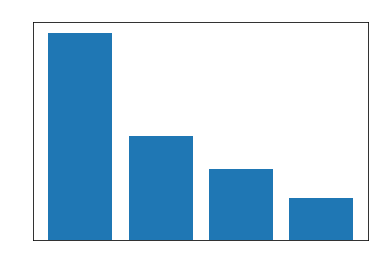

In [ ]:
import matplotlib.pyplot as plt



size=[cnn_model_size/1000,quantized_cnn_model_size/1000,pruned_cnn_model_size/1000,quantized_pruned_cnn_model_size/1000]
label=['cnn','quant_cnn_tflite','prune_cnn','quant_pruned_cnn']

print("Size of gzipped baseline Keras model: %.2f KB" % (cnn_model_size/1000))
print("Size of gzipped quantized Keras tflite model: %.2f KB" % (quantized_cnn_model_size/1000))
print("Size of gzipped pruned Keras model: %.2f KB" % (pruned_cnn_model_size/1000))
print("Size of gzipped quantized and pruned TFlite model: %.2f KB" % (quantized_pruned_cnn_model_size/1000))

plt.bar(label,height=size)
title_obj=plt.title('Size of baseline and pruned keras file')
plt.setp(title_obj, color='w')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

Accuracy baseline Keras model: 92.53 bytes
Accuracy Keras tflite model: 93.86 bytes
Accuracy pruned Keras model: 93.86 bytes
Accuracy pruned TFlite model: 93.86 bytes


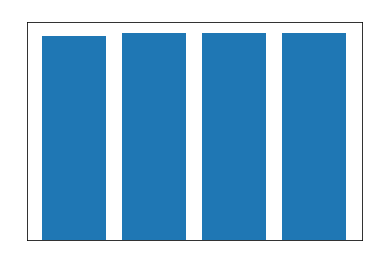

In [ ]:
model_accuracy=[score,cnn_tflite_accuracy,model_for_pruning_accuracy*100,quantized_pruned_cnn_model_accuracy]
label=['keras_file','keras_tflite_file','pruned_keras_file','pruned_tflite_file']

print("Accuracy baseline Keras model: %.2f bytes" % (score))
print("Accuracy Keras tflite model: %.2f bytes" % (cnn_tflite_accuracy))
print("Accuracy pruned Keras model: %.2f bytes" % (model_for_pruning_accuracy*100))
print("Accuracy pruned TFlite model: %.2f bytes" % (quantized_pruned_cnn_model_accuracy))

plt.bar(label,height=model_accuracy)
title_obj=plt.title('Size of baseline and pruned keras file')
plt.setp(title_obj, color='w')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()